# Style Transfer with Deep Neural Networks

In [1]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## VGG 19 (as Feature Extractor)

In [2]:
# classifier is discarded
vgg = models.vgg19(pretrained=True).features

# freezing the layers as weights require no training
for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:24<00:00, 23.2MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Load in Content and Style Images

In [3]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    
    print(image.size)
    if max(image.size) > max_size:
        size = max_size    #for faster processing
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape    #for manual size adjusting
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),    # resizing
                        transforms.ToTensor(),      # converting image to tensor
                        transforms.Normalize((0.485, 0.456, 0.406),     
                                             (0.229, 0.224, 0.225))])    #normalization to predefined means (one for each channel)

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension using unsqueeze
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [4]:
# kaggle
import os
os.listdir('../input/')

['octopus.jpg',
 'hockney.jpg',
 'delaunay.jpg',
 'sotomayor.jpg',
 'magritte.jpg',
 'ben_passmore.jpg',
 'octavia.jpg',
 'space_needle.jpg',
 'kahlo.jpg',
 'janelle.png']

In [5]:
# images loaded on the same device as model fo faster computations
content = load_image('../input/space_needle.jpg').to(device)
#style = load_image('../input/ben_passmore.jpg', shape=content.shape[-2:]).to(device) # Resizing style to match content
style = load_image('../input/delaunay.jpg', shape=content.shape[-2:]).to(device) # Resizing style to match content

(1409, 847)
(480, 586)


In [6]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()   #cloning
    image = image.numpy().squeeze()   #converting into numpy
    image = image.transpose(1,2,0) 
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) #denormalization
    image = image.clip(0, 1)
    return image

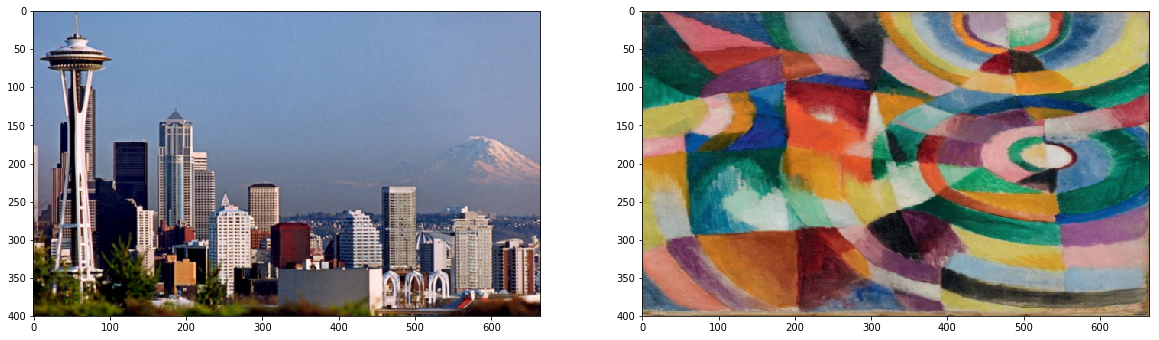

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

---
## VGG19 Architecture (features only)

In [8]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Content and Style Features

In [9]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # content layer
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 

`batch_size, d, h, w = tensor.size`.
Gram Matrix: `torch.mm(matrix1, matrix1_transpose)`

In [10]:
'''
    8x4x4 = 1x128
    here 4x4 pixel matrix gives 16 cols & 8 is depth of convolution layer.
'''
def gram_matrix(tensor):
    #step1: getting depth(number of maps), height, width of image
    _, d, h, w = tensor.size()
    #step2: Vectorization of feature maps
    tensor = tensor.view(d, h * w)
    #step3: Gram Matrix calculation
    gram = torch.mm(tensor, tensor.t())
    return gram 

In [11]:
# get content and style features only once (before training)
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

#traget image (clone)
target = content.clone().requires_grad_(True).to(device)

## Content Loss and Style Loss

In [12]:
'''we use higher weights for initial layers as they have more features.
these weights are adjusted to improve target image quality'''

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

'''keep in mind that as a/b gets smaller and smaller, style gets dominating over content
total Loss = (a x content loss) + (b x style loss)
a (alpha) and b (beta) are used for scaling of losses.'''

content_weight = 1  # a
style_weight = 1e6  # b (large to keep styling prominent)

## Iteration & Back-propagation

Total loss:  16700256.0


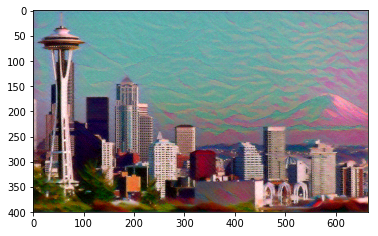

Total loss:  6315632.0


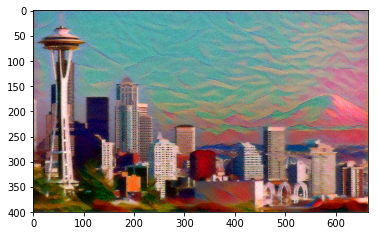

Total loss:  2804482.25


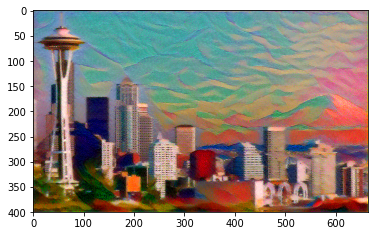

Total loss:  1443703.375


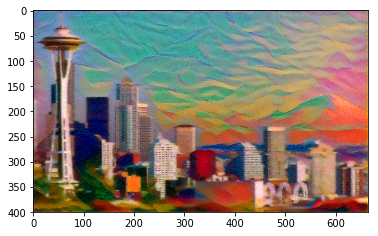

Total loss:  808736.4375


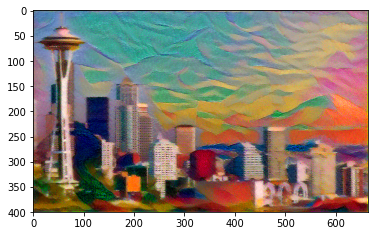

In [13]:
show_every = 400
optimizer = optim.Adam([target], lr=0.003)
steps = 2000

for ii in range(1, steps+1):
    # get the features from your target image
    target_features = get_features(target, vgg)    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    # the style loss (initialize the style loss to 0)
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)   # divide by image size to normalize the loss
        
    # calculate the *total* loss
    total_loss = (content_weight * content_loss) + (style_weight * style_loss)
    
    # Back Propagation
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

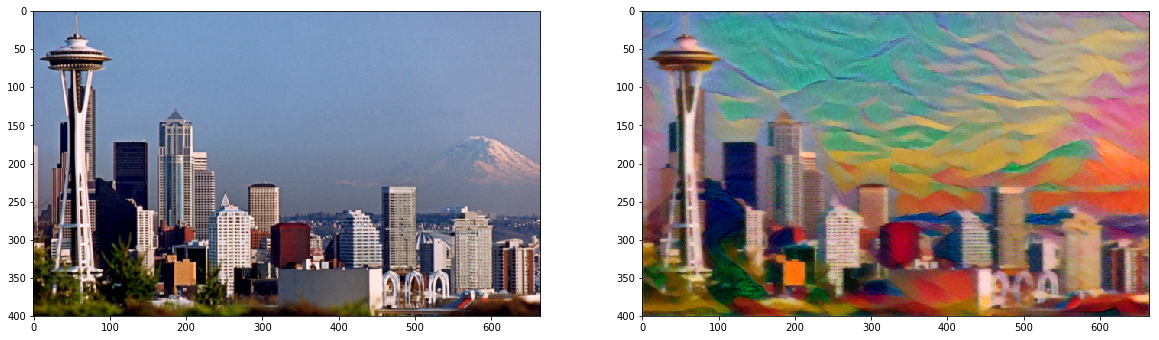

In [14]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))